# Imports

In [221]:
import sklearn.model_selection
import spacy
import requests
import os
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
import itertools
import seaborn as sns
import lightgbm
import tsfresh

# Helper Methods

In [18]:
def get_fileNames(category: str):
    file_names = []
    for files in os.listdir("../Data/" + category):
        if files.endswith(".csv"):
            files = files[0:len(files)-4]
            file_names.append(files)
    return file_names

In [3]:
def smape(target, forecast):
    if type(target) == pd.core.frame.DataFrame:
        target = target.values

    denominator = np.abs(target) + np.abs(forecast)
    flag = denominator == 0.

    smape = 2 * np.mean(
        (np.abs(target - forecast) * (1 - flag)) / (denominator + flag)
    )
    return smape

In [88]:
def make_data(category, article, days_to_predict):
    df = pd.read_csv(f"../Data/{category}/{article}.csv")

    df.index = df["timestamp"]
    df.drop(["project", "article", 'granularity', 'access', 'agent', 'timestamp'], axis=1, inplace=True)
    df.index = pd.to_datetime(df.index)

    df["views"] = np.log(df["views"])

    #dfN = df[["views"]].copy()
    #df["target"] = df.views.shift(-1)
    df.dropna(inplace=True)
    df = create_features(df)

    #df = df.loc[(df.index >= '2015.01.01') & (df.index <= "2021.01.01")]
    dfNeu = df.tail(days_to_predict)
    df = df.head(len(df) - days_to_predict)

    return df, dfNeu

# Features

In [10]:
def create_features(df):
    if isinstance(df, tuple):
        df = df[0]
    df = df.copy()
    df["dayofweek"] = df.index.dayofweek
    df["month"] = df.index.month
    df["quarter"] = df.index.quarter
    df["dayofyear"] = df.index.dayofyear
    df["year"] = df.index.year
    df["max"] = max(df["views"])
    df["min"] = min(df["views"])
    df["avg"] = sum(df["views"]) / len(df["views"])
    return df

def create_features2(df, dfNeu):
    if isinstance(df, tuple):
        df = df[0]

    df = df.copy()
    dfNeu["dayofweek"] = dfNeu.index.dayofweek
    dfNeu["month"] = dfNeu.index.month
    dfNeu["quarter"] = dfNeu.index.quarter
    dfNeu["dayofyear"] = dfNeu.index.dayofyear
    dfNeu["year"] = dfNeu.index.year
    dfNeu["max"] = max(df["views"])
    dfNeu["min"] = min(df["views"])
    dfNeu["avg"] = sum(df["views"]) / len(df["views"])
    return dfNeu

# XGBoost

In [107]:
FEATURES = ["dayofweek", "month", "quarter", "dayofyear", "year", "min", "max", "avg"]
TARGET = "views"
xgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)

In [218]:
def train_test_xg(category, model, days_to_predict):
    train_test = []
    neu = []
    for i in category:
        for file in get_fileNames(i):
            df, df_new_data = make_data(i, file, days_to_predict)
            train_test.append(df)
            neu.append((df_new_data, file))
    train_xg(train_test, model)
    losses = test_neu_xg(neu, model)
    return losses

def train_xg(dfs, model):
    df_all = pd.concat(dfs)
    print(len(df_all))
    train_data, test_data = sklearn.model_selection.train_test_split(df_all, test_size=0.3, random_state=69)

    X_train = train_data[FEATURES]
    y_train = train_data[TARGET]
    X_test = test_data[FEATURES]
    y_test = test_data[TARGET]

    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=1000)

def test_neu_xg(dfs, model):
    losses = []
    for df in dfs:
        file = df[1]
        df = df[0]
        X_neu = df[FEATURES]
        df["prediction"] = model.predict(X_neu)
        loss = smape(df["views"], df["prediction"])
        losses.append(loss)

        print(f"{file}: {loss}")
        df["views"].plot()
        df["prediction"].plot()
        plt.grid()
        plt.legend()
        plt.show()

    return losses
xgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)
losses_music = train_test_xg(["Music"], xgmodel, 14)
xgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)
losses_games = train_test_xg(["Games"], xgmodel, 14)
xgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)
losses_movies = train_test_xg(["Movies"], xgmodel, 14)
xgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)
losses_literary = train_test_xg(["Literary"], xgmodel, 14)
xgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)
lossess_all = train_test_xg(["Games", "Music", "Movies", "Literary"], xgmodel, 14)

'\nxgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)\nlosses_music = train_test_xg(["Music"], xgmodel, 14)\nxgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)\nlosses_games = train_test_xg(["Games"], xgmodel, 14)\nxgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)\nlosses_movies = train_test_xg(["Movies"], xgmodel, 14)\nxgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_rate=0.01, eval_metric=smape, disable_default_eval_metric=True, max_depth=6, gamma=0.1)\nlosses_literary = train_test_xg(["Literary"], xgmodel, 14)\nxgmodel = xgb.XGBRegressor(n_estimators=100000, early_stopping_rounds=50, learning_ra

<AxesSubplot: >

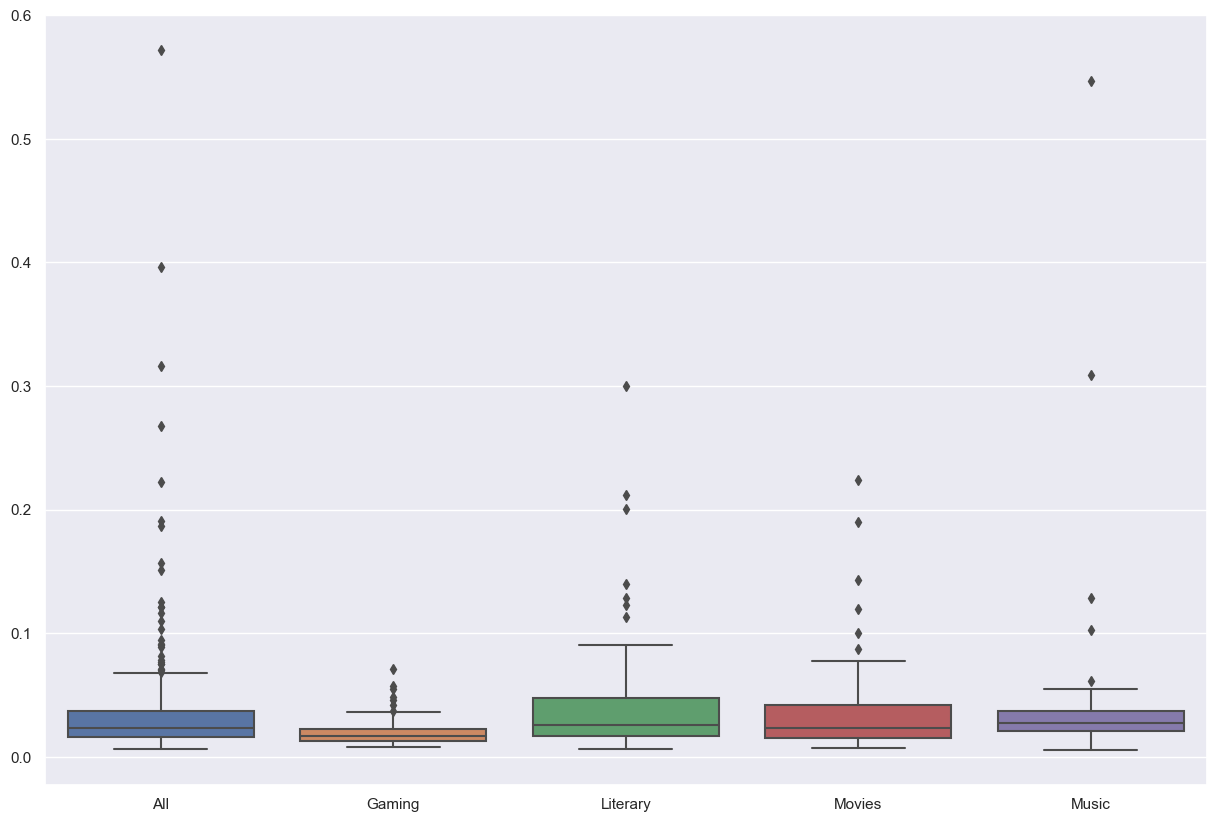

In [219]:
df_games = pd.DataFrame({"Gaming": losses_games,})
df_music = pd.DataFrame({"Music": losses_music,})
df_movies = pd.DataFrame({"Movies": losses_movies,})
df_literary = pd.DataFrame({"Literary": losses_literary,})
df_all_losses = pd.DataFrame({"All": lossess_all})
df_all = pd.concat([df_all_losses, df_games, df_literary, df_movies, df_music], axis=1)
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(data=df_all)

<AxesSubplot: xlabel='Length', ylabel='Average'>

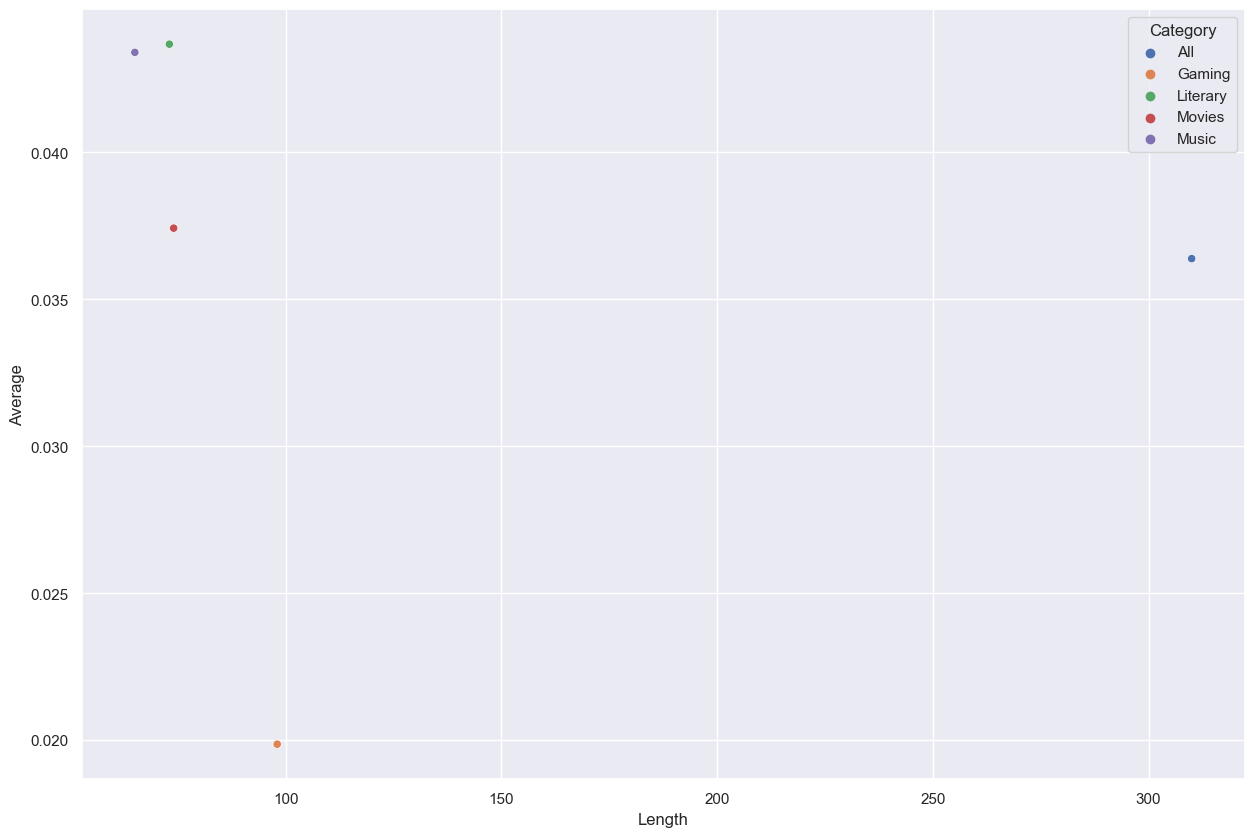

In [210]:
def avg(x):
    return sum(x) / len(x)
df_scatter = pd.DataFrame({
    "Category": ["All", "Gaming", "Literary", "Movies", "Music"],
    "Average": [avg(lossess_all) ,avg(losses_games), avg(losses_literary), avg(losses_movies), avg(losses_music)],
    "Length": [len(lossess_all), len(losses_games), len(losses_literary), len(losses_movies), len(losses_music)]
})

sns.scatterplot(data=df_scatter, x="Length", y="Average", hue="Category")

<AxesSubplot: >

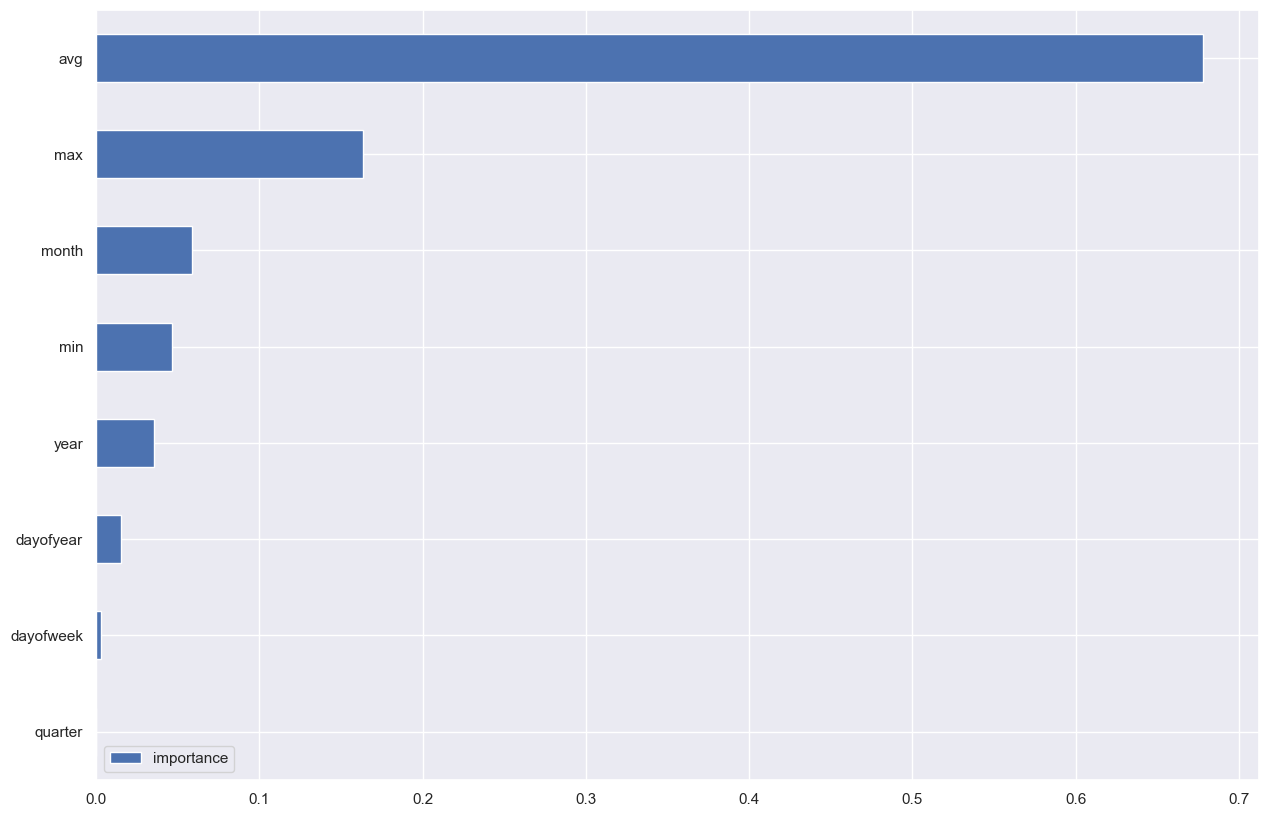

In [220]:
fi = pd.DataFrame(data=xgmodel.feature_importances_,
                  index=xgmodel.feature_names_in_,
                  columns=["importance"])
fi.sort_values("importance").plot(kind="barh")

# Light GBM